**Statistical Modelling Approach**
- Use Dag diagram as guidance for what variables and interactions to look at in Logistic Model
- Data Preperation
- Model Selection
- Verify Model Assumptions
- Model Goodness of fit
- Model Interpretation

**Data Preperation**

In [2]:
import pandas as pd

df=pd.read_csv('prepared_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440832 entries, 0 to 440831
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Age                440832 non-null  float64
 1   Gender             440832 non-null  object 
 2   Tenure             440832 non-null  float64
 3   Usage Frequency    440832 non-null  float64
 4   Support Calls      440832 non-null  float64
 5   Payment Delay      440832 non-null  float64
 6   Subscription Type  440832 non-null  object 
 7   Contract Length    440832 non-null  object 
 8   Total Spend        440832 non-null  float64
 9   Last Interaction   440832 non-null  float64
 10  Churn              440832 non-null  float64
 11  Total Usage        440832 non-null  float64
 12  Age Cat            440832 non-null  object 
 13  Support Cat        440832 non-null  object 
dtypes: float64(9), object(5)
memory usage: 47.1+ MB


In [3]:
# Drop Variables that had no association with Churn from EDA
# Gender and Subscription Type had not association or interaction effects
# Dropping age and support calls since we found suitable categories using k means algorithm
# df=df.drop(columns=['Gender','Subscription Type'])

In [4]:
df['Churn']=df['Churn'].astype(int)

In [5]:
# Create dummy variables for all categorical variables

categorical_columns=df.select_dtypes(include='object').columns.tolist()

In [6]:
# check levels of categorical variables to be included in the model
for col in categorical_columns:
    df[col]=df[col].astype('category')
    print("Levels in {}: {}".format(col,df[col].cat.categories))


Levels in Gender: Index(['Female', 'Male'], dtype='object')
Levels in Subscription Type: Index(['Basic', 'Premium', 'Standard'], dtype='object')
Levels in Contract Length: Index(['Annual', 'Monthly', 'Quarterly'], dtype='object')
Levels in Age Cat: Index(['Middle Aged Adult', 'Senior Adult', 'Young Adult'], dtype='object')
Levels in Support Cat: Index(['High', 'Low', 'Medium'], dtype='object')


In [7]:
# create a deep copy of df so that we do not change df object in memory
df_new=df.copy()
df_new.columns=df_new.columns.str.replace(" ","_")
df_new.columns

Index(['Age', 'Gender', 'Tenure', 'Usage_Frequency', 'Support_Calls',
       'Payment_Delay', 'Subscription_Type', 'Contract_Length', 'Total_Spend',
       'Last_Interaction', 'Churn', 'Total_Usage', 'Age_Cat', 'Support_Cat'],
      dtype='object')

**Model Selection**

In [8]:
import statsmodels.formula.api as smf

In [9]:
model1=smf.logit(formula='Churn ~ Tenure',data=df_new).fit(maxiter=300)
print(model1.summary())
print("AIC: {}".format(model1.aic))
print("BIC: {}".format(model1.bic))


Optimization terminated successfully.
         Current function value: 0.682764
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:               440832
Model:                          Logit   Df Residuals:                   440830
Method:                           MLE   Df Model:                            1
Date:                Tue, 14 Jan 2025   Pseudo R-squ.:                0.001972
Time:                        17:06:35   Log-Likelihood:            -3.0098e+05
converged:                       True   LL-Null:                   -3.0158e+05
Covariance Type:            nonrobust   LLR p-value:                1.094e-260
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4610      0.006     72.672      0.000       0.449       0.473
Tenure        -0.0061      0.

In [10]:
model2=smf.logit(formula='Churn ~ Tenure+Usage_Frequency',data=df_new).fit(maxiter=300)
print(model2.summary())
print("AIC: {}".format(model2.aic))
print("BIC: {}".format(model2.bic))

# The addition of the Usage Frequency Variable did not impact the parameter estimates and standard errors much
# suggest multicollinearity was not introduced into the model

Optimization terminated successfully.
         Current function value: 0.681631
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:               440832
Model:                          Logit   Df Residuals:                   440829
Method:                           MLE   Df Model:                            2
Date:                Tue, 14 Jan 2025   Pseudo R-squ.:                0.003628
Time:                        17:06:37   Log-Likelihood:            -3.0048e+05
converged:                       True   LL-Null:                   -3.0158e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.6442      0.009     74.681      0.000       0.627       0.661
Tenure        

In [11]:
import scipy.stats
import statsmodels.api as sm
import scipy
# has the addition of usage frequency improved the model
# perfrom liklihood ratio test to verify

# H0: Additional covariate did not improve the model
# H1: Additional covariate improved the model

def likihood_ratio_test(full_model,reduced_model):
    lr_statistic=2 * (full_model.llf - reduced_model.llf)
    dof = full_model.df_model - reduced_model.df_model
    p_value = scipy.stats.chi2.sf(lr_statistic,dof)

    if p_value<0.05:
        print("Additional predictor improved the model")
    else:
        print("Additional predictor did not improve the model")

likihood_ratio_test(full_model=model2,reduced_model=model1)


Additional predictor improved the model


In [12]:
model3=smf.logit(formula='Churn ~ Tenure+Usage_Frequency+Payment_Delay',data=df_new).fit(maxiter=300)
print(model3.summary())
print("AIC: {}".format(model3.aic))
print("BIC: {}".format(model3.bic))

# The addition of Payment delay did not increase parameter estimates and standard errors by much
# suggests not issue of multicollinearity

Optimization terminated successfully.
         Current function value: 0.630909
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:               440832
Model:                          Logit   Df Residuals:                   440828
Method:                           MLE   Df Model:                            3
Date:                Tue, 14 Jan 2025   Pseudo R-squ.:                 0.07777
Time:                        17:06:49   Log-Likelihood:            -2.7812e+05
converged:                       True   LL-Null:                   -3.0158e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.3967      0.010    -38.514      0.000      -0.417      -0.376
Tenure        

In [13]:
# Did the addition of Payment Delay improve the model?

likihood_ratio_test(full_model=model3,reduced_model=model2)

Additional predictor improved the model


In [14]:
model4=smf.logit(formula='Churn ~ Tenure+Usage_Frequency+Payment_Delay+Total_Spend',data=df_new).fit(maxiter=300)
print(model4.summary())
print("AIC: {}".format(model4.aic))
print("BIC: {}".format(model4.bic))

# The addition of Total Spend did not increase the parameter estimates and standard errors by much
# suggesting total spend does not introduce multicolinearity into the model

Optimization terminated successfully.
         Current function value: 0.534441
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:               440832
Model:                          Logit   Df Residuals:                   440827
Method:                           MLE   Df Model:                            4
Date:                Tue, 14 Jan 2025   Pseudo R-squ.:                  0.2188
Time:                        17:06:52   Log-Likelihood:            -2.3560e+05
converged:                       True   LL-Null:                   -3.0158e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.5426      0.016    156.486      0.000       2.511       2.574
Tenure        

In [15]:
# Did adding Total Spend improve the model?
likihood_ratio_test(full_model=model4,reduced_model=model3)


Additional predictor improved the model


In [16]:
model5=smf.logit(formula='Churn ~ Tenure+Usage_Frequency+Payment_Delay+Total_Spend + Last_Interaction',data=df_new).fit(maxiter=300)
print(model5.summary())
print("AIC: {}".format(model5.aic))
print("BIC: {}".format(model5.bic))

# The addition of Last Interaction did not increase the parameter estimates and standard errors by much
# suggesting Last Interaction does not introduce multicollinearity into the model

Optimization terminated successfully.
         Current function value: 0.525379
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:               440832
Model:                          Logit   Df Residuals:                   440826
Method:                           MLE   Df Model:                            5
Date:                Tue, 14 Jan 2025   Pseudo R-squ.:                  0.2320
Time:                        17:06:54   Log-Likelihood:            -2.3160e+05
converged:                       True   LL-Null:                   -3.0158e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            2.0234      0.017    117.230      0.000       1.990       2.057
Tenure     

In [17]:
# Does the addition of last interaction improve the model?
likihood_ratio_test(full_model=model5,reduced_model=model4)

Additional predictor improved the model


In [18]:
# Gender did not seem to have an association with Churn , however it could still have an impact on churn when adjusting for other predictors
# we will add gender to the model and see what effects it has on the parameter estimates and standard errors

model6=smf.logit(formula='Churn ~ Tenure+Usage_Frequency+Payment_Delay+Total_Spend + Last_Interaction + Gender',data=df_new).fit(maxiter=300)
print(model6.summary())
print("AIC: {}".format(model6.aic))
print("BIC: {}".format(model6.bic))


Optimization terminated successfully.
         Current function value: 0.507925
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:               440832
Model:                          Logit   Df Residuals:                   440825
Method:                           MLE   Df Model:                            6
Date:                Tue, 14 Jan 2025   Pseudo R-squ.:                  0.2575
Time:                        17:06:57   Log-Likelihood:            -2.2391e+05
converged:                       True   LL-Null:                   -3.0158e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            2.4565      0.018    135.707      0.000       2.421       2.492
Gender[T.Ma

In [19]:
# Does the addition of Gender improve the model?
likihood_ratio_test(full_model=model6,reduced_model=model5)

Additional predictor improved the model


In [20]:
df_new.columns

Index(['Age', 'Gender', 'Tenure', 'Usage_Frequency', 'Support_Calls',
       'Payment_Delay', 'Subscription_Type', 'Contract_Length', 'Total_Spend',
       'Last_Interaction', 'Churn', 'Total_Usage', 'Age_Cat', 'Support_Cat'],
      dtype='object')

In [21]:
# Next will add the support cat var we created when doing feature engineering
model7=smf.logit(formula='Churn ~ Tenure+Usage_Frequency+Payment_Delay+Total_Spend + Last_Interaction + Gender +Support_Cat',data=df_new).fit(maxiter=300)
print(model7.summary())
print("AIC: {}".format(model7.aic))
print("BIC: {}".format(model7.bic))

# introducing support cat var into the model introduces a problem of quasi-separation
# which causes the model to not converge and blows up the parameter estimates and standard errors
# The issue with this predictor is the following
# None of the customers who did not churn belonged to the high support category as from the the EDA
# We will have to drop the predictor and rather include the numeric predictor support_calls




         Current function value: 0.327767
         Iterations: 300


c:\Users\Dillon Reichman\Documents\Machine Leanring Bootcamp\Classification Project Customer Churn\env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:               440832
Model:                          Logit   Df Residuals:                   440823
Method:                           MLE   Df Model:                            8
Date:                Tue, 14 Jan 2025   Pseudo R-squ.:                  0.5209
Time:                        17:07:28   Log-Likelihood:            -1.4449e+05
converged:                      False   LL-Null:                   -3.0158e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                28.6681   1091.488      0.026      0.979   -2110.610    2167.946
Gender[T.Male]           -1.0595      0.010   -107.146      0.000      -1.079      -1.040
Support_

In [22]:
model7=smf.logit(formula='Churn ~ Tenure+Usage_Frequency+Payment_Delay+Total_Spend + Last_Interaction + Gender +Support_Calls',data=df_new).fit(maxiter=300)
print(model7.summary())
print("AIC: {}".format(model7.aic))
print("BIC: {}".format(model7.bic))

# Additional of the Support Calls predictor has not changed the parameter estimates and standard errors much

Optimization terminated successfully.
         Current function value: 0.339032
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:               440832
Model:                          Logit   Df Residuals:                   440824
Method:                           MLE   Df Model:                            7
Date:                Tue, 14 Jan 2025   Pseudo R-squ.:                  0.5044
Time:                        17:07:30   Log-Likelihood:            -1.4946e+05
converged:                       True   LL-Null:                   -3.0158e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.8351      0.023     36.142      0.000       0.790       0.880
Gender[T.Ma

In [23]:
# Has the addition of the Support Calls variable improved the model?
likihood_ratio_test(full_model=model7,reduced_model=model6)


Additional predictor improved the model


In [24]:
# Based on the problem we had with the support_cat predictor
# we will have the same problem with the age_cat predictor since 
# all senior adults churned 
# The predictor was useful for exploring relationships in the data but including it will introduce quasi seperation and the model will not converge
# We will instead include the cat var Age

model8=smf.logit(formula='Churn ~ Tenure+Usage_Frequency+Payment_Delay+Total_Spend + Last_Interaction + Gender +Support_Calls+Age',data=df_new).fit(maxiter=300)
print(model8.summary())
print("AIC: {}".format(model8.aic))
print("BIC: {}".format(model8.bic))

# The inclusion of Age has not impacted the parameter estimates and standard errors by much

Optimization terminated successfully.
         Current function value: 0.330942
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:               440832
Model:                          Logit   Df Residuals:                   440823
Method:                           MLE   Df Model:                            8
Date:                Tue, 14 Jan 2025   Pseudo R-squ.:                  0.5162
Time:                        17:07:33   Log-Likelihood:            -1.4589e+05
converged:                       True   LL-Null:                   -3.0158e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.4431      0.028    -15.907      0.000      -0.498      -0.388
Gender[T.Ma

In [25]:
# Has Age improved the model?
likihood_ratio_test(full_model=model8,reduced_model=model7)


Additional predictor improved the model


In [26]:
# Inclusion of the Contract Length variable will also create an issue of quasi seperation
# since all monthly contract churned
# It was still useful in EDA as we observed that a high number of suppport calls had a relationship with monthly contracts churning

In [27]:
df_new.columns

Index(['Age', 'Gender', 'Tenure', 'Usage_Frequency', 'Support_Calls',
       'Payment_Delay', 'Subscription_Type', 'Contract_Length', 'Total_Spend',
       'Last_Interaction', 'Churn', 'Total_Usage', 'Age_Cat', 'Support_Cat'],
      dtype='object')

In [28]:
# Subscription_Type did not seem to have an association with Churn
# perhaps it does when we adjust for the other predictor variables

model9=smf.logit(formula='Churn ~ Tenure+Usage_Frequency+Payment_Delay+Total_Spend + Last_Interaction + Gender +Support_Calls+Age +Subscription_Type',data=df_new).fit(maxiter=300)
print(model9.summary())
print("AIC: {}".format(model9.aic))
print("BIC: {}".format(model9.bic))

# The inclusion of Subscription_Type does not seems to impact parameter estimates and standard errors much and is a significant predictor

Optimization terminated successfully.
         Current function value: 0.330805
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:               440832
Model:                          Logit   Df Residuals:                   440821
Method:                           MLE   Df Model:                           10
Date:                Tue, 14 Jan 2025   Pseudo R-squ.:                  0.5164
Time:                        17:07:35   Log-Likelihood:            -1.4583e+05
converged:                       True   LL-Null:                   -3.0158e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -0.3653      0.029    -12.710      0.

In [29]:
# Does Subscription_Type improve the model?
likihood_ratio_test(full_model=model9,reduced_model=model8)


Additional predictor improved the model


In [30]:
# We created a Total_Usage variable from Tenure and Usage Frequency 
# We cannot include all 3 variables since they are highly correlated with each other 
# Including them will introduce multicollinearity

# What we will do is fit a model with Total_Usage and not Tenure and Usage Frequency -*
# Compare model in * with model 9

model10=smf.logit(formula='Churn ~ Payment_Delay+Total_Spend + Last_Interaction + Gender +Support_Calls+Age +Subscription_Type+Total_Usage',data=df_new).fit(maxiter=300)
print(model10.summary())
print("AIC: {}".format(model10.aic))
print("BIC: {}".format(model10.bic))

# Including Total_Usage did not seem to have impact on parameter estimates and standard errors

Optimization terminated successfully.
         Current function value: 0.331433
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:               440832
Model:                          Logit   Df Residuals:                   440822
Method:                           MLE   Df Model:                            9
Date:                Tue, 14 Jan 2025   Pseudo R-squ.:                  0.5155
Time:                        17:07:38   Log-Likelihood:            -1.4611e+05
converged:                       True   LL-Null:                   -3.0158e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -0.6517      0.027    -24.567      0.

In [31]:
# Which model is better between model with total usage and model without total usage
likihood_ratio_test(full_model=model9,reduced_model=model10)

# Based on the likelihood ratio test, model 9 without Total Usage is a better model.

Additional predictor improved the model


In [32]:
model9.resid_dev

0         0.728571
1         0.057925
2         0.057160
3         0.128067
4         0.850681
            ...   
440827   -0.291368
440828   -0.769304
440829   -0.124381
440830   -0.320258
440831   -0.826043
Length: 440832, dtype: float64

**Conclutions Model Selection**
- Model 9 is the best performing model
- We reached this conclustion using the liklihood ratio test and iteratively adding predictor variables to the model
- at each iteration we also looked at the impact on the parameter estimates and standard errors to see if we had an issue of multicollinearity

**Verify Model Assumptions**
- Outcome variable is Binary - our outcome variable is churn which is binary
- Linearity of independent numeric vars with log odds
- Absence of multicollinearity (Use VIF)
- Independence of observations

**Linearity of independent numeric vars with log odds**

In [33]:
import numpy as np
predicted=model9.predict(df_new)
log_odds=np.log(predicted/(1-predicted))
numeric_cols=df_new.select_dtypes(include='number').columns.tolist()
to_remove=['Churn','Total_Usage']
numeric_cols_final=[x for x in numeric_cols if x not in to_remove]



In [34]:
log_odds

0         1.190850
1         6.389528
2         6.416143
3         4.799441
4         0.830221
            ...   
440827   -3.138182
440828   -1.066083
440829   -4.858087
440830   -2.944653
440831   -0.899932
Length: 440832, dtype: float64

In [35]:
predicted

0         0.766893
1         0.998324
2         0.998368
3         0.991833
4         0.696402
            ...   
440827    0.041559
440828    0.256149
440829    0.007705
440830    0.049990
440831    0.289064
Length: 440832, dtype: float64

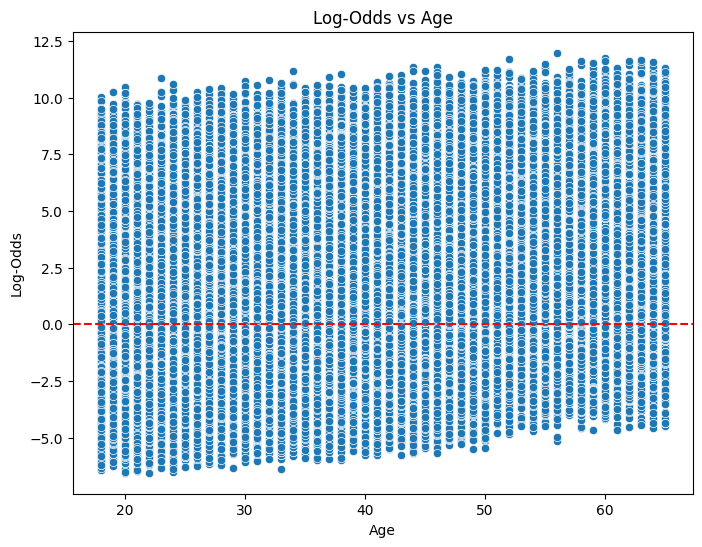

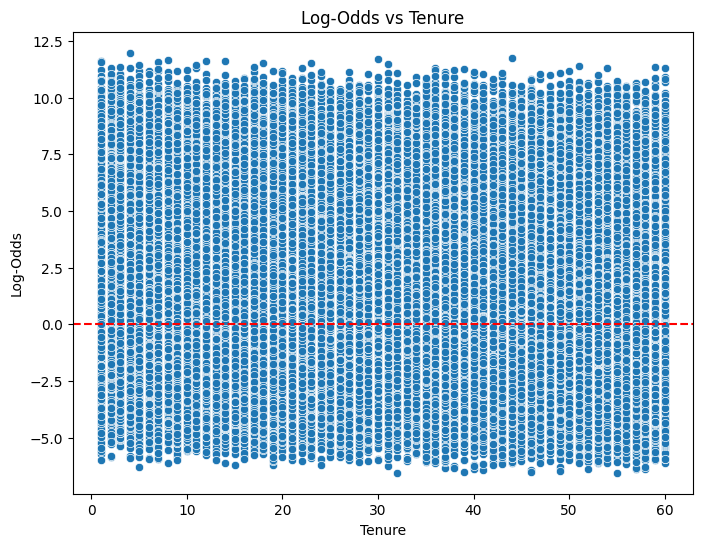

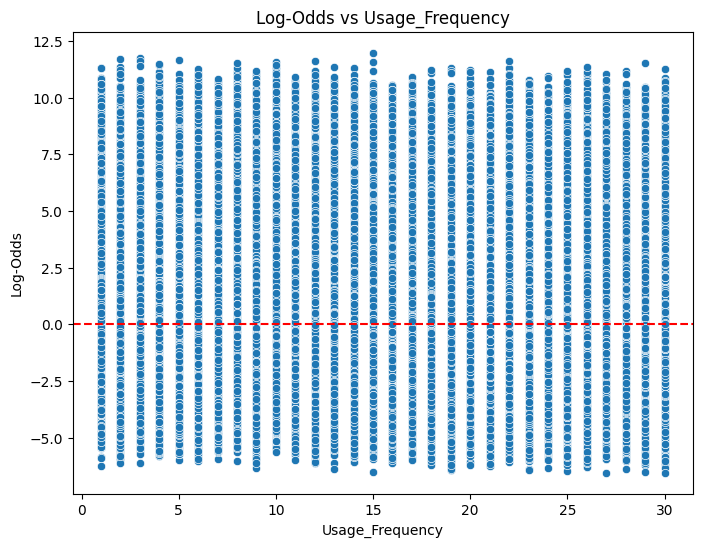

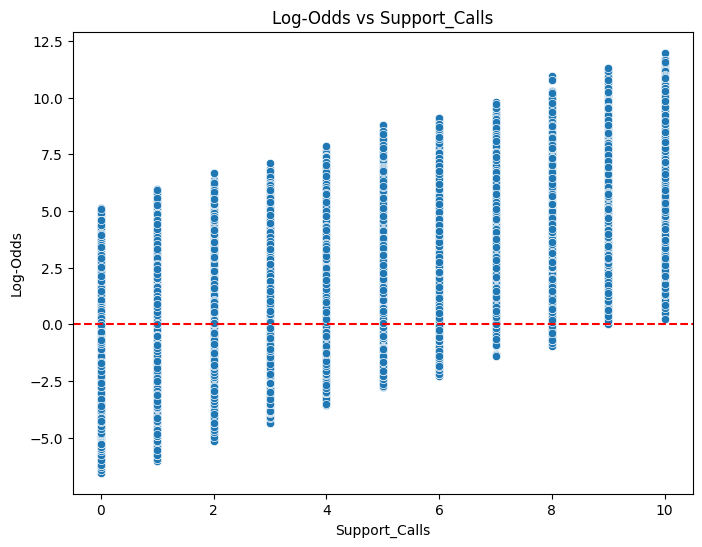

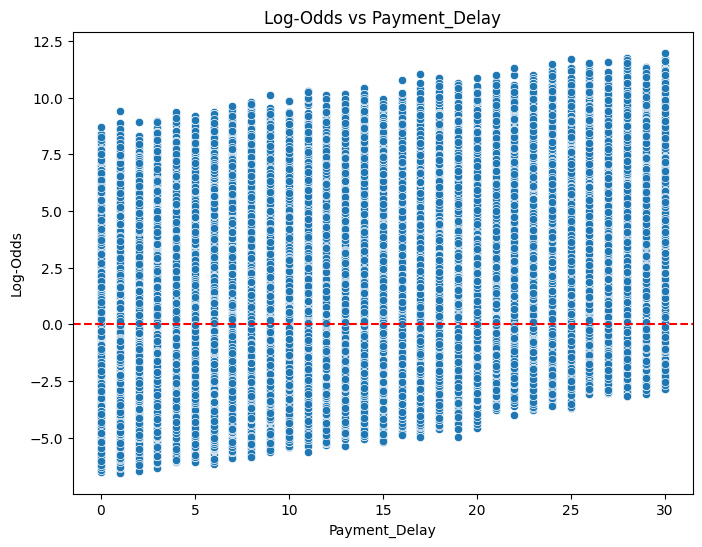

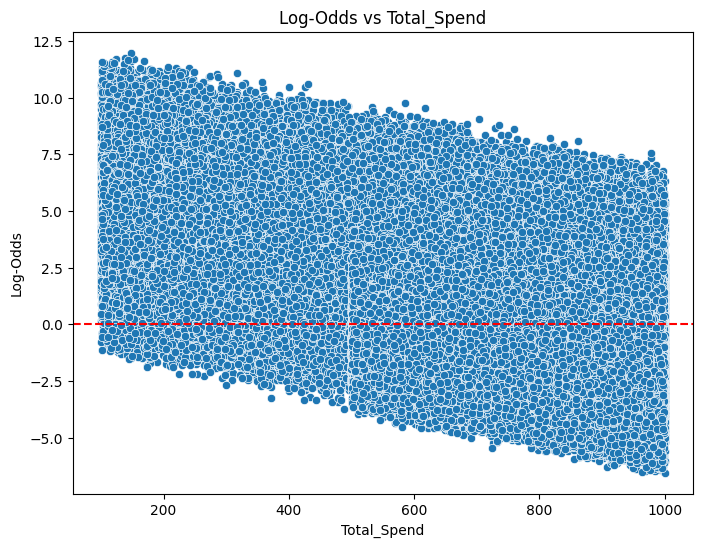

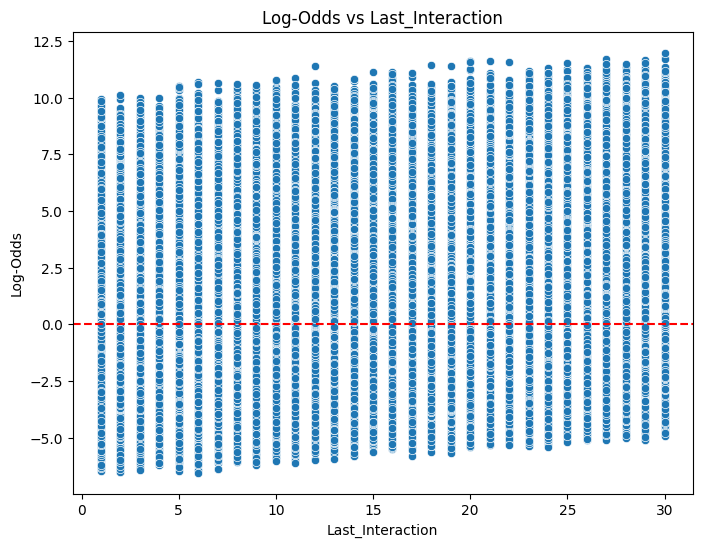

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

for var in numeric_cols_final:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df_new[var], y=log_odds)
    plt.title(f'Log-Odds vs {var}')
    plt.xlabel(var)
    plt.ylabel('Log-Odds')
    plt.axhline(0, color='red', linestyle='--')  # Optional: Adds a horizontal line at 0
    plt.show()

# all numeric vars look linear with the log odds 

In [37]:
df_new.columns

Index(['Age', 'Gender', 'Tenure', 'Usage_Frequency', 'Support_Calls',
       'Payment_Delay', 'Subscription_Type', 'Contract_Length', 'Total_Spend',
       'Last_Interaction', 'Churn', 'Total_Usage', 'Age_Cat', 'Support_Cat'],
      dtype='object')

In [38]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440832 entries, 0 to 440831
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   Age                440832 non-null  float64 
 1   Gender             440832 non-null  category
 2   Tenure             440832 non-null  float64 
 3   Usage_Frequency    440832 non-null  float64 
 4   Support_Calls      440832 non-null  float64 
 5   Payment_Delay      440832 non-null  float64 
 6   Subscription_Type  440832 non-null  category
 7   Contract_Length    440832 non-null  category
 8   Total_Spend        440832 non-null  float64 
 9   Last_Interaction   440832 non-null  float64 
 10  Churn              440832 non-null  int64   
 11  Total_Usage        440832 non-null  float64 
 12  Age_Cat            440832 non-null  category
 13  Support_Cat        440832 non-null  category
dtypes: category(5), float64(8), int64(1)
memory usage: 32.4 MB


**Absense of Multicollinearity**

In [39]:
# look at the VIF
# We have to create a design matrix
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor


design_matrix_df=df_new.drop(columns=['Churn','Contract_Length','Support_Cat','Age_Cat','Total_Usage']).copy()
cat_cols=design_matrix_df.select_dtypes(include='category').columns
design_matrix_dummy_vars=pd.get_dummies(design_matrix_df,columns=cat_cols,drop_first=True).astype(int)
# Add constant for intercept
design_matrix_dummy_vars=add_constant(design_matrix_dummy_vars)
vif_data=pd.DataFrame()
vif_data['Variable']=design_matrix_dummy_vars.columns
vif_data['VIF']=[variance_inflation_factor(design_matrix_dummy_vars.values,i) for i in range(design_matrix_dummy_vars.shape[1])]

In [40]:
vif_data

,Variable,VIF
0,const,36.538080
1,Age,1.030084
2,Tenure,1.002693
3,Usage_Frequency,1.001595
4,Support_Calls,1.105471
5,Payment_Delay,1.038557
6,Total_Spend,1.066657
7,Last_Interaction,1.030763
8,Gender_Male,1.033945
9,Subscription_Type_Premium,1.352709


**Conclutions Multicollinerity**
- All variables selected for the final model have a VIF < 5 which indicates no multicollinearity

**Independence of observations**

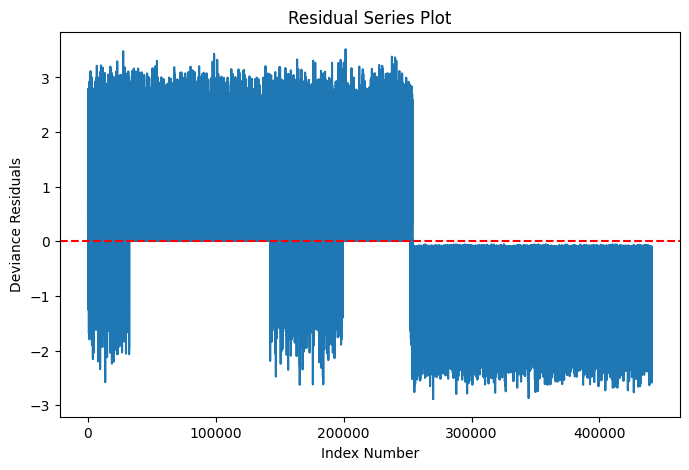

In [41]:
# Generate residual series plot
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, title="Residual Series Plot",
                    xlabel="Index Number", ylabel="Deviance Residuals")

# ax.plot(X.index.tolist(), stats.zscore(logit_results.resid_pearson))
ax.plot(design_matrix_dummy_vars.index.tolist(), model9.resid_dev)
plt.axhline(y=0, ls="--", color='red');

**Conclutions for independent observations**
- Observations seems to be independent since residuals are random around the axis y=0

**Model Goodness of fit**

In [42]:
# possible tests to use are the Hosmer-Lemeshow test but according to the litriture
# this test has low statistical power and a result one cannot trust the conclustion we get get from the test
# https://en.wikipedia.org/wiki/Hosmer%E2%80%93Lemeshow_test

# we will look at other metrics such as ROC Curve AUC and metrics from the confusion matrix to evaluate
# How well the model predicts / generalises to unseen data
from sklearn.metrics import roc_auc_score,roc_curve

predicted_probs=model9.predict(df_new)

fpr,tpr,thresholds=roc_curve(df_new['Churn'],predicted_probs)

auc=roc_auc_score(df_new['Churn'],predicted_probs)
print("AUC:", auc)


AUC: 0.9284069225485791


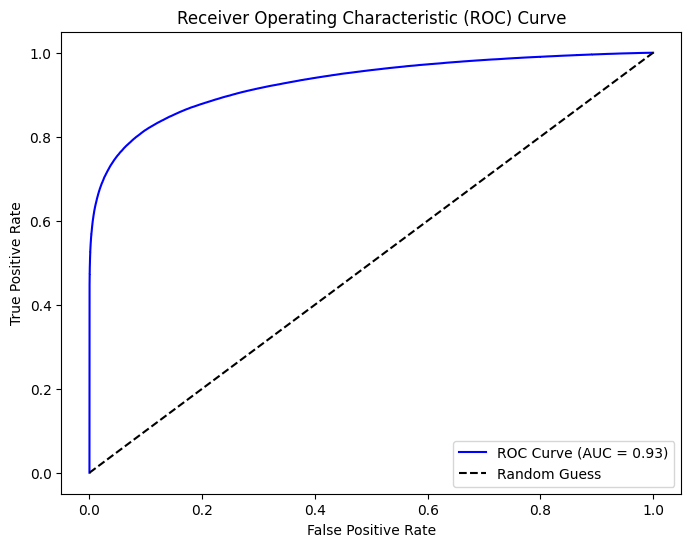

In [43]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

**Conclutions from the ROC Curve**
- AUC of 0.93 which is amazing!
- This tells us that the model will assign a higher probability to a postive case (churning case) 93% of the time
- It would seem the model has great discriminating power when discrimating between churn and not churning
- This indicates that the model performs well on the data it was trainined on
- Understanding if the model performs well on unseen data will test the models ability to generalise to unseen data
- From a stats perspective we have fitted the correct model that will allow us to understand the factors that are associated with churn
- and will allow us to understand the effect size that each factor has on the response variable

**Model Interpretation**

In [44]:
conf_intervals=pd.DataFrame(model9.conf_int()).reset_index()
param_est=pd.DataFrame(model9.params).reset_index()

In [52]:
conf_intervals.rename(columns={'index':'Variable',0:'Lower Bound',1:'Upper Bound'},inplace=True)

In [56]:
param_est.rename(columns={'index':'Variable',0:'Parameter estimate'},inplace=True)

In [59]:
import math
e=math.e

In [61]:
param_est['Odds Ratio']=e**(param_est['Parameter estimate'])

In [62]:
param_est

,Variable,Parameter estimate,Odds Ratio
0,Intercept,-0.365288,0.693996
1,Gender[T.Male],-1.051587,0.349383
2,Subscription_Type[T.Premium],-0.111346,0.894629
3,Subscription_Type[T.Standard],-0.108048,0.897584
4,Tenure,-0.007071,0.992954
5,Usage_Frequency,-0.013215,0.986872
6,Payment_Delay,0.101895,1.107267
7,Total_Spend,-0.005415,0.994599
8,Last_Interaction,0.054657,1.056179
9,Support_Calls,0.677621,1.969188


**Conclutions**
- The odds of churn for males are 66% lower than the odds for females when adjusting for other predictors
- The odds of churn for customers who have a premuim subscription is 11 % lower than the odds of churn for customers who have a basic subscription when adjusting for other predictors
- The odds of churn for customers who have a Standard subscription is 11 % lower than the odds of churn for customers who have a basic subscription when adjusting for other predictors
- For a unit increase in Tenure (months), the odds of churning is 0.7 % lower when adjusting for other predictors
- For a unit increase in Usage Frequency , the odds of churning is 1.31 % lower when adjusting for other predictors
- 10.7 % increase in the odds of churn for a unit increase in Payment Delay , when adjusting for other predictors
- For a unit increase in Total Spend , the odds of churning is 0.54 % lower when adjusting for other predictors
- 5.61 % incrase in the odds of churn for a unit increase in Last Interaction when adjusting for other predictors
- The odds of churn increase by 96.92 % for a unit increase in support calls when adjusting for other predictors. This is clearly a massive one to address if you want to reduce customer churn.
- The odds of churn increase by 3.46 % for a unit increase in Age when adjusting for other predictors